In [59]:
import os
import sys
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv
load_dotenv()

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_absolute_error

import bambi as bmb
import arviz as az
import xarray as xr

import lightgbm as lgb

sys.path.append('../')

from sqlalchemy import create_engine
from database.queries import get_game_stats

warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
pd.set_option('display.max_columns', 100)

In [2]:
# loading up the postgres credentials
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
database = os.getenv('DB_NAME')
port = os.getenv('DB_PORT')

# # creating the URI for the database
URI = f'postgresql://{user}:{password}@{host}:{port}/{database}'

# # establishing a connection to the database
engine = create_engine(URI)

In [3]:
lee_sharpe_query = """
    select *
    from lee_sharpe
    where season >= 2012
"""

ls = pd.read_sql(lee_sharpe_query, URI)

In [4]:
# changing the names in the Lee Sharpe dataframe to match the names in the 
# nflfastr dataframe. This will allow us to combine data more easily, 
# using game_id. 

lv_home_condition = (ls['home_team'] == 'OAK') & (ls['season'] < 2020)
lv_away_condition = (ls['away_team'] == 'OAK') & (ls['season'] < 2020)
ls.loc[lv_home_condition, 'home_team'] = 'LV'
ls.loc[lv_away_condition, 'away_team'] = 'LV'

la_home_condition = (ls['home_team'] == 'STL') & (ls['season'] < 2016)
la_away_condition = (ls['away_team'] == 'STL') & (ls['season'] < 2016)
ls.loc[la_home_condition, 'home_team'] = 'LA'
ls.loc[la_away_condition, 'away_team'] = 'LA'

lac_home_condition = (ls['home_team'] == 'SD') & (ls['season'] < 2017)
lac_away_condition = (ls['away_team'] == 'SD') & (ls['season'] < 2017)
ls.loc[lac_home_condition, 'home_team'] = 'LAC'
ls.loc[lac_away_condition, 'away_team'] = 'LAC'

In [5]:
query = """
    select *
    from player_stats
    where season >=2012 and position = 'QB'
    order by season asc, week asc
"""
df = pd.read_sql(query, con=engine)

In [6]:
# getting game ids by week from the lee sharpe data. starting with home then
# using update to get the away team game ids
game_id_dict = ls.set_index(['season', 'week', 'home_team'])['game_id'].to_dict()
ls_gameid_away = ls.set_index(['season', 'week', 'away_team'])['game_id'].to_dict()

game_id_dict.update(ls_gameid_away)

# assigning game ids to the player stats dataframe using the game id dictionary
df['game_id'] = 'NA'
df['game_id'] = [game_id_dict[(s, w, t)] if (s, w, t) in game_id_dict else 'NA' for s, w, t in zip(df.season, df.week, df.recent_team)]

print("there are now", df[df['game_id'] == 'NA'].shape[0], "missing game ids")

there are now 0 missing game ids


In [7]:
# merging the lee sharpe data with the player stats data
df = df.merge(ls, how='left', on=['game_id', 'season', 'week'], validate='many_to_one')

# limit the dataset to only quarterbacks who started the game
cond = (df['player_id'] == df['home_qb_id']) | (df['player_id'] == df['away_qb_id'])

starters = df[cond].copy()
starters.reset_index(drop=True, inplace=True)

# are there any missing game ids in lee sharpe
set(ls.game_id.unique()).difference(set(starters.game_id.unique()))

set()

In [8]:
def ewm_player_statistics(data=None, alpha=None, min_periods=None):
    
    data_mean = data.shift().ewm(alpha=alpha, min_periods=min_periods).mean()
    
    return data_mean

In [9]:
# manually creating exponentially weighted moving averages for several statistics

starters['ewm_passing_yards'] = (
        starters.groupby('player_id')['passing_yards'].transform(lambda x: ewm_player_statistics(x, 0.08, 1))
    )

starters['ewm_passing_epa'] = (
        starters.groupby('player_id')['passing_epa'].transform(lambda x: x.shift().ewm(alpha=0.08, min_periods=1).mean())
    )

starters['ewm_passing_attempts'] = (
        starters.groupby('player_id')['attempts'].transform(lambda x: ewm_player_statistics(x, 0.08, 1))
    )

In [17]:
# getting the team spread for each qb
starters['team_spread'] = (
    starters
    .apply(lambda x: x['spread_line'] * -1 if x['recent_team'] == x['home_team'] else x['spread_line'], axis=1)
)


In [30]:
# getting the defensive team for each game and calculating 
# an exponentially weighted moving average for passing ep
# allowed - note, fix the neutral games!!!
starters['defteam'] = (
    starters
    .apply(lambda x: x['away_team'] if x['home_team'] == x['recent_team'] else x['away_team'], axis=1)
)

starters['defteam_ewm_passing_yards'] =(
    starters
    .groupby(['defteam'])['passing_yards']
    .transform(lambda x: x.shift().ewm(alpha=0.052, min_periods=1).mean())
)

# Simple Linear Model, Simple Train-Test

In [18]:
# limiting quarterbacks to those with more than 5

games_played = starters.groupby('player_id').size().reset_index(name='count')
more_than_5 = games_played[games_played['count'] >= 5]['player_id'].tolist()

In [22]:
features = ['ewm_passing_yards', 'ewm_passing_attempts',
          'wind', 'passing_yards', 'temp', 'week',
          'total_line', 'team_spread']

model_df = starters[features].copy()
model_df['wind'] = model_df['wind'].fillna(0)
model_df['temp'] = model_df['temp'].fillna(72)
model_df.dropna(subset=['ewm_passing_yards'], inplace=True)

model = RidgeCV()

X = model_df.drop('passing_yards', axis=1)
# scaling it
for col in X.columns:
    X[f'{col}'] = (X[f'{col}'] - X[f'{col}'].mean()) / X[f'{col}'].std()
y = model_df['passing_yards']

X_train, X_test = X.iloc[:4000].copy(), X.iloc[4000:].copy()
y_train, y_test = y.iloc[:4000].copy(), y.iloc[4000:].copy()

model.fit(X_train, y_train)

RidgeCV()

In [23]:
# creating a dataframe with the model params
model_params_df = pd.DataFrame({x:y for x, y in zip(X.columns, model.coef_)}, index=[0])
model_params_df.insert(0, 'intercept', model.intercept_)

model_params_df.T

,0
intercept,245.830013
ewm_passing_yards,7.715253
ewm_passing_attempts,8.166972
wind,-5.779728
temp,0.832159
week,-4.206711
total_line,17.208963
team_spread,-10.416790


In [26]:
# how did this simple model do on the simple test set?
# it does beat the ewm for passing yards on its own

print(mean_absolute_error(y_test, model.predict(X_test)))

58.79726518332153


# Multilevel Model in Bambi

In [31]:
X_train['passing_yards'] = y_train.values
X_train['player_id'] = starters[starters.index.isin(X_train.index)]['player_id'].values
X_train['def_py'] = starters[starters.index.isin(X_train.index)]['defteam_ewm_passing_yards'].values

X_test['passing_yards'] = y_test.values
X_test['player_id'] = starters[starters.index.isin(X_test.index)]['player_id'].values
X_test['def_py'] = starters[starters.index.isin(X_test.index)]['defteam_ewm_passing_yards'].values

In [40]:
# lets try to specify this model in bambi and see what we can do

model = bmb.Model('passing_yards ~ ewm_passing_yards + total_line + team_spread + week +  \
                    ewm_passing_attempts + wind + (1 | player_id)', data=X_train, dropna=True)
results = model.fit(draws=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [passing_yards_sigma, Intercept, ewm_passing_yards, total_line, team_spread, week, ewm_passing_attempts, wind, 1|player_id_sigma, 1|player_id_offset]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 42 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [41]:
az.summary(results).head(10)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,240.024,2.676,235.085,245.046,0.096,0.068,788.0,981.0,1.0
ewm_passing_yards,0.167,2.931,-5.162,5.735,0.079,0.058,1387.0,1457.0,1.0
total_line,17.181,1.512,14.619,20.012,0.029,0.021,2678.0,1338.0,1.0
team_spread,-9.772,1.401,-12.457,-7.278,0.026,0.019,2918.0,1731.0,1.0
week,-4.980,1.204,-7.295,-2.734,0.019,0.014,4115.0,1537.0,1.0
ewm_passing_attempts,6.795,2.394,2.154,11.137,0.049,0.037,2379.0,1748.0,1.0
wind,-6.010,1.286,-8.531,-3.588,0.021,0.016,3637.0,1408.0,1.0
passing_yards_sigma,74.376,0.829,72.827,75.946,0.016,0.011,2818.0,1477.0,1.0
1|player_id_sigma,16.747,3.247,10.860,23.197,0.152,0.108,452.0,857.0,1.0
1|player_id[00-0000865],4.019,16.523,-24.300,36.201,0.263,0.431,3928.0,1341.0,1.0


In [42]:
# there are two different ways of extracting predictions
# we can either sample the posterior mean, or we can 
# sample from the pps, or the posterior predictive distribution

X_test_posterior = (
    model.predict(
        results,
        data=X_test,
        sample_new_groups=True,
        inplace=False)
)

predictions = X_test_posterior.posterior['passing_yards_mean'][0]
X_test['preds'] = pd.DataFrame(predictions).mean().values

print("the MAE of the linear model is:", mean_absolute_error(y_test, X_test['preds']))

the MAE of the linear model is: 58.81930655051719


In [43]:
# getting the posterior predictive distributions. these include
# all of the parameter uncertainty along with the uncertainty
# from the data generating process. in other words, we generate predictions
# by samplin the posterior for a specific set of data

X_test_posterior_predictive = (
    model.predict(
        results,
        kind='pps',
        data=X_test,
        sample_new_groups=True,
        inplace=False)
)

pps_predictions = X_test_posterior_predictive.posterior_predictive['passing_yards'][0]

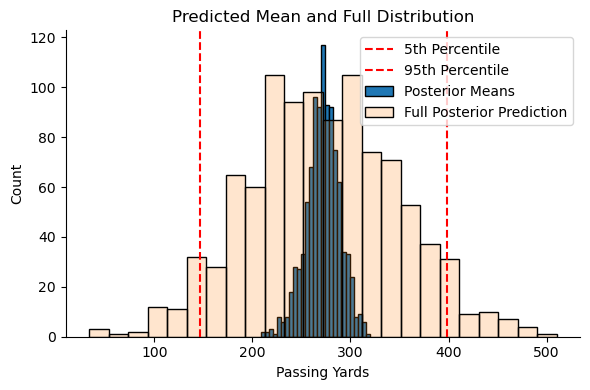

In [62]:
GAME_NUM = 444

game_mean = pd.DataFrame(predictions)[GAME_NUM]
game_pps = pd.DataFrame(pps_predictions)[GAME_NUM]

fifth = game_pps.quantile(0.05)
ninetyfifth = game_pps.quantile(0.95)

fig, ax = plt.subplots(figsize=(6,4))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

sns.histplot(game_mean, label="Posterior Means", alpha=1)
sns.histplot(game_pps, label="Full Posterior Prediction", alpha=0.2)

plt.axvline(fifth, color='r', linestyle='--', label="5th Percentile")
plt.axvline(ninetyfifth, color='r', linestyle='--', label="95th Percentile")

plt.title("Predicted Mean and Full Distribution")
plt.xlabel("Passing Yards")
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
X_test['90th'] = pd.DataFrame(pps_predictions).quantile(0.9).values
X_test['95th'] = pd.DataFrame(pps_predictions).quantile(0.95).values
X_test['10th'] = pd.DataFrame(pps_predictions).quantile(0.1).values
X_test['5th'] = pd.DataFrame(pps_predictions).quantile(0.05).values

print("coverage from 5th to 95th quantile", 
      X_test[X_test['passing_yards'].between(X_test['5th'], X_test['95th'])].shape[0] / X_test.shape[0]
     )

coverage from 5th to 95th quantile 0.9002267573696145


In [87]:
lgb_model = lgb.LGBMRegressor(objective='quantile', alpha=0.5, max_depth=3)
lgb_q5_model = lgb.LGBMRegressor(objective='quantile', alpha=0.05, max_depth=3)
lgb_q95_model = lgb.LGBMRegressor(objective='quantile', alpha=0.95, max_depth=3)

lgb_model.fit(X_train[features].drop(columns='passing_yards'), y_train)
lgb_q5_model.fit(X_train[features].drop(columns='passing_yards'), y_train)
lgb_q95_model.fit(X_train[features].drop(columns='passing_yards'), y_train)

lgb_mean_pred = lgb_model.predict(X_test[features].drop(columns='passing_yards'))
lgb_q5_pred = lgb_q5_model.predict(X_test[features].drop(columns='passing_yards'))
lgb_q95_pred = lgb_q95_model.predict(X_test[features].drop(columns='passing_yards'))

In [90]:
X_test['lgb_mean'] = lgb_mean_pred
X_test['lgb_q5'] = lgb_q5_pred
X_test['lgb_q95'] = lgb_q95_pred